In [29]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
import getpass, json, string

#open remote browser
browser = webdriver.PhantomJS()
browser.get('https://vamps2.mbl.edu/users/login')

def attempt_login():
    user = input("Enter your VAMPS username: ")
    password = getpass.getpass("Enter your VAMPS password: ")
    browser.find_element_by_id("username").send_keys(user)
    browser.find_element_by_id("password").send_keys(password)
    browser.find_element_by_id("password").submit();
    return browser.current_url

attempt_login()

while browser.current_url == 'https://vamps2.mbl.edu/users/login':
    print("Incorrect username and/or password, try again")
    browser.find_element_by_id("username").clear()
    browser.find_element_by_id("password").clear()
    attempt_login()
    WebDriverWait(browser, 5)
    

file = input("Enter JSON Config File: ")
dataset = input("Enter the dataset you want to view (e.g. 'AB_SAND_Bv6'): ")

visualizations = ["dheatmap", "piecharts", "barcharts", "counts_matrix", "metadata_table", "fheatmap", "dendrogram01", "dendrogram03", "pcoa", "pcoa3d", "geospatial", "adiversity"]
image = input('Enter image to display ("dheatmap", "piecharts", "barcharts", "counts_matrix", "metadata_table", "fheatmap", "dendrogram01", "dendrogram03", "pcoa", "pcoa3d", "geospatial", "adiversity"): ')
while image not in visualizations:
    print("Not a valid image option")
    image = input('Enter image to display: ')

Enter your VAMPS username: ruzics
Enter your VAMPS password: ········
Enter JSON Config File: test_config.json
Enter the dataset you want to view (e.g. 'AB_SAND_Bv6'): AB_SAND_Bv6
Enter image to display ("dheatmap", "piecharts", "barcharts", "counts_matrix", "metadata_table", "fheatmap", "dendrogram01", "dendrogram03", "pcoa", "pcoa3d", "geospatial", "adiversity"): piecharts


In [30]:
#xpath to select dataset in VAMPS
xpath = "//*[@id='projects_select_div']/div/table/tbody/tr[td[2]/table/tbody/tr/td[4]/span/span[text()='" + dataset + "']]/td[2]/table/tbody/tr/td[2]/div"               

browser.get('https://vamps2.mbl.edu/visuals/visuals_index')
timeout = 30
element_present = EC.presence_of_element_located((By.XPATH, xpath)) #wait for dataset checkbox to load
WebDriverWait(browser, timeout).until(element_present)

<selenium.webdriver.remote.webelement.WebElement (session="c5ff0070-59dc-11e7-92d2-bdee774c5866", element=":wdc:1498419087434")>

In [31]:
#select dataset
browser.find_element_by_xpath(xpath).click()
browser.find_element_by_xpath(xpath).click()

In [32]:
#click to visuals page
browser.save_screenshot('visual.png')
browser.find_element_by_xpath("//*[@id='selection_btn_visuals']").click()

timeout = 30
element_present = EC.presence_of_element_located((By.XPATH, "//*[@id='dataset_names_div']/table/tbody"))
WebDriverWait(browser, timeout).until(element_present)

#grab dataset IDs and parse 
find_id = browser.find_elements_by_xpath("//*[@id='dataset_names_div']/table/tbody")
ids_list = []

line = find_id[0].text
for y in range(len(line)):
            if line[y] == '(':
                num = ''
                y += 1
                while line[y] != ')':
                    if line[y] != 'i' and line[y] != 'd' and line[y] != ':':
                        num += line[y]
                    y += 1
                ids_list.append(num)

In [33]:
with open(file) as f:
    config_string = json.load(f)

#change config file to match new image/dataset 
if 'names' in config_string['id_name_hash']:
    del config_string['id_name_hash']['names']
config_string['image'] = image
config_string['id_name_hash']['ids'] = ids_list

#rewrite config file
with open(file,'w') as f:
    f.write(json.dumps(config_string))

In [34]:
#upload new config file to VAMPS remotely
browser.save_screenshot('screen.png')
browser.get('https://vamps2.mbl.edu/user_data/upload_configuration')
uploadElement = browser.find_element_by_name("upload_files")
uploadElement.send_keys(file);
browser.find_element_by_name("upload_files").submit()

In [35]:
link = image + '_open_btn'
browser.find_element_by_id(link).click() #click to open vizualization in new window
main_window_handle = browser.current_window_handle #save old browser
signin_window_handle = None
while not signin_window_handle:
    for handle in browser.window_handles: #find new browser in all current browsers
        if handle != main_window_handle:
            signin_window_handle = handle
            break
#switch to the vizualization window and save screenshot
browser.switch_to.window(signin_window_handle) 
browser.maximize_window()
browser.save_screenshot('visual.png')
browser.switch_to.window(main_window_handle)

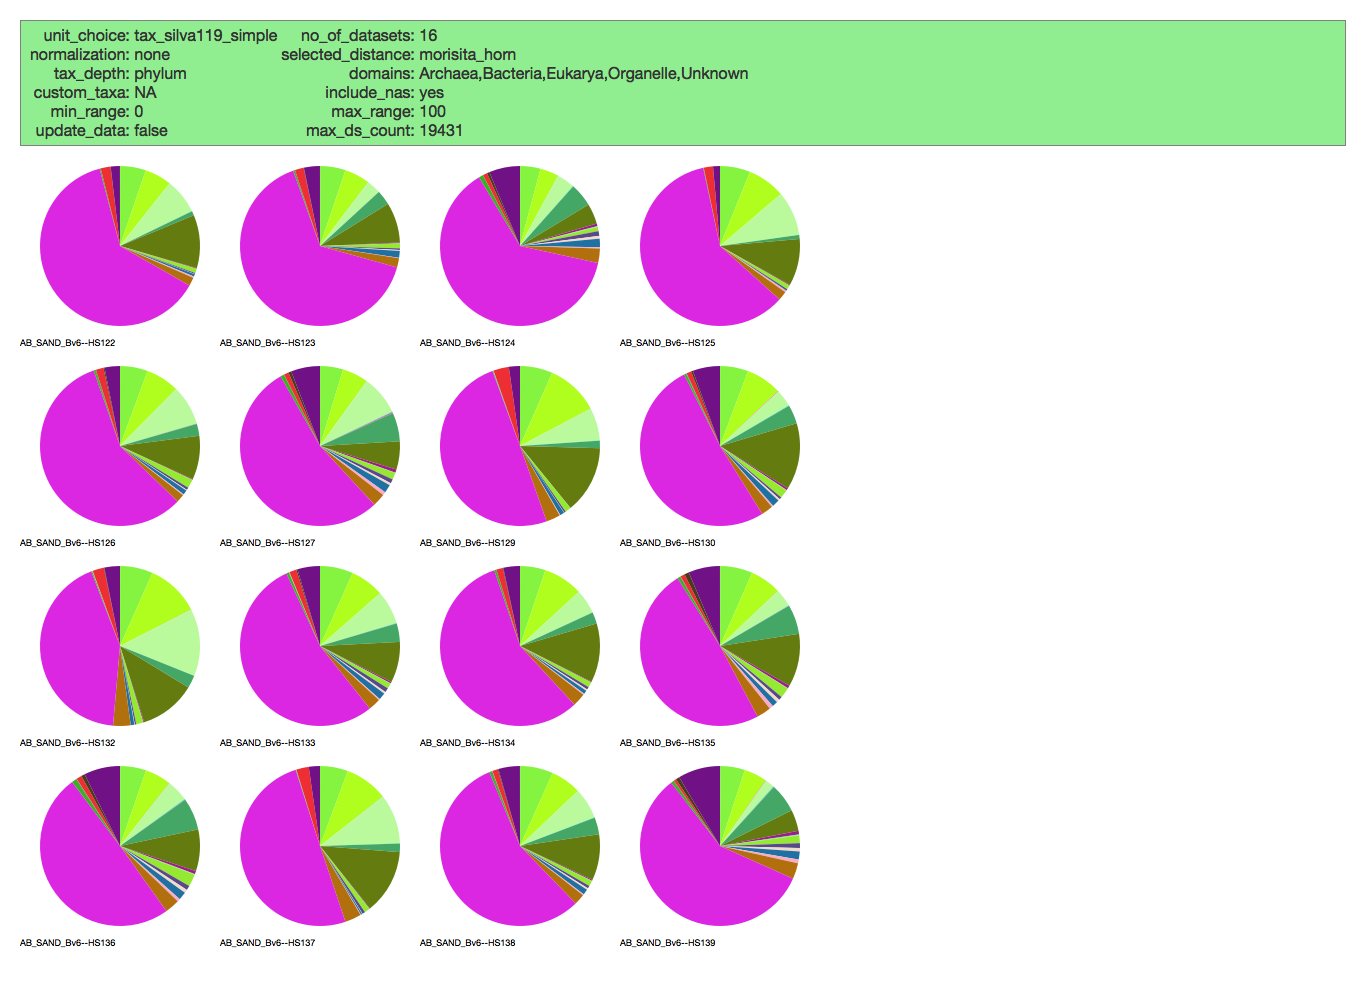

In [36]:
#display visualization screenshot
from IPython.display import Image
Image(filename='visual.png') 